# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using  the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-14 10:59:18]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-14 10:59:19]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065795 which means the difference is 0.4192321649392312.
The relative difference is 0.02744360869838739%.


# 2. GCI vs GCI3 steps
$D= \sum_i B_i Z_i$
and Group commutator

In [5]:


from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *


eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)


In [36]:
# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci.loss(0.0024545454545454545, MagneticFieldEvolutionOracle(b_list,name = "D(linear)"))


-14.935548641736634

In [31]:
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
eo_d = MagneticFieldEvolutionOracle(b_rand2)

## First we try the reduced GC

This has the cost 3x VQE + 1x Hamiltonian simulation (HS)

-14.964561986392079


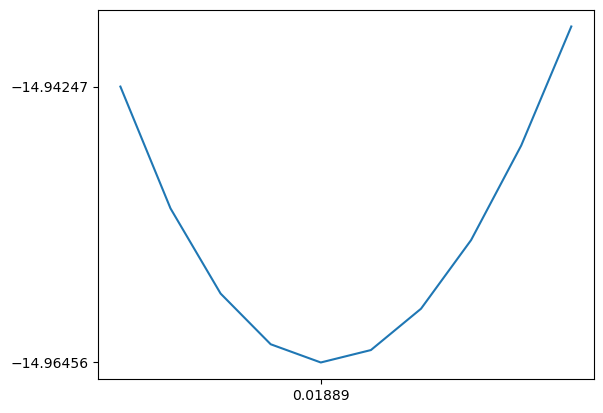

In [37]:
losses = []
times = np.linspace(1e-2,3e-2,10)
for s in times:
    losses.append(gci.loss(s, eo_d))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gci_1 = times[np.argmin(losses)]

## Next we try the reduced GC3

This has the cost 5x VQE + 2x Hamiltonian simulation (HS)

-14.97453545263959


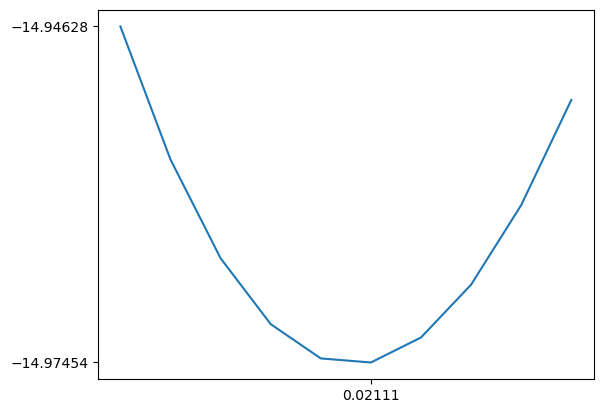

In [41]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-2,3e-2,10)

for s in times:
    losses.append(gci.loss(s, eo_d))
vplt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

## Finally we try the reduced GC twice

This has again the cost 5x VQE + 2x HS so anytime we try GC3 we can try to run 2x GC1

-14.992048411338113


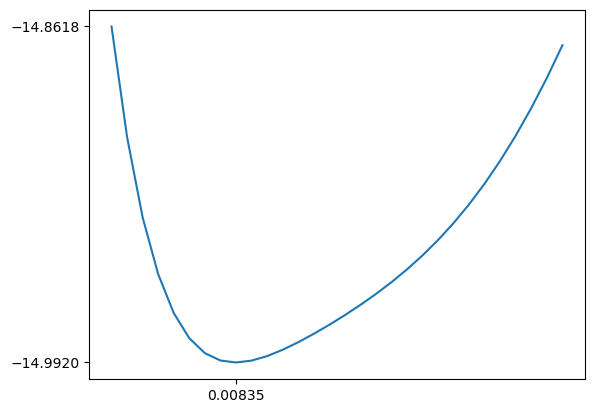

In [48]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_reduced

c1 = gci.get_composed_circuit()
losses = []
times_double = np.linspace(1e-4,3e-2,30)
for s in times_double:
    c0 = gci.group_commutator(s, eo_d)["forwards"]
    losses.append(hamiltonian.expectation((c0+c0+c1)().state()))

plt.plot(times_double,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times_double[np.argmin(losses)]])
print(min(losses))
s_gc1_2_step = times_double[np.argmin(losses)]

## Finally we try the reduced GC twice

This has the cost 3x VQE + 1x Hamiltonian simulation (HS)

In [49]:
c0 = gci.group_commutator(s_gc1_2_step, eo_d)["forwards"]
v1_circ = c0+c0+c1
hamiltonian.expectation((c0+c0+c1)().state())

-14.992048411338113

In [50]:

fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-14.992048411338113

In [52]:
gci2.print_gate_count_report()


The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-15.025112583778384


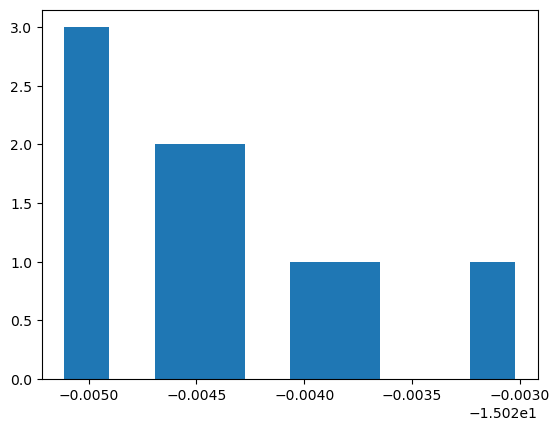

In [53]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(10):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))

In [10]:
print(np.min(losses))
f = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]


-14.975405132922273


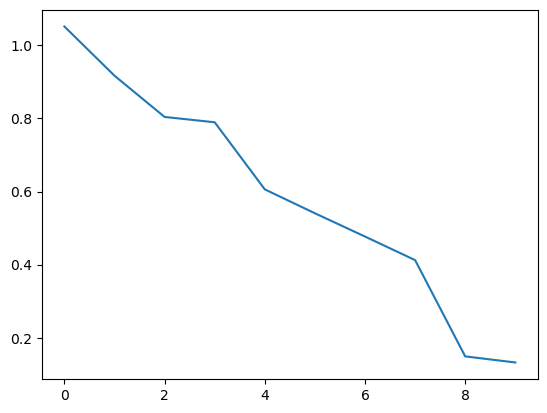

In [11]:
plt.plot(f)


(array([1., 0., 0., 0., 0., 6., 0., 0., 0., 3.]),
 array([0.01943636, 0.01958727, 0.01973818, 0.01988909, 0.02004   ,
        0.02019091, 0.02034182, 0.02049273, 0.02064364, 0.02079455,
        0.02094545]),
 <BarContainer object of 10 artists>)

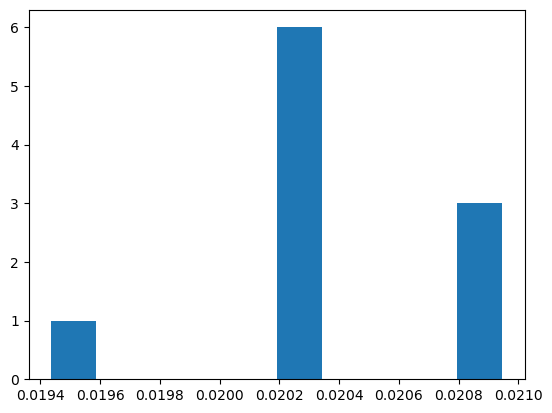

In [12]:
plt.hist(steps)

-14.945798178813995


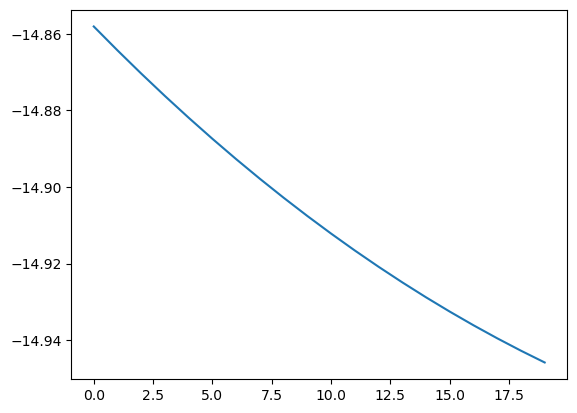

-14.967713857597507


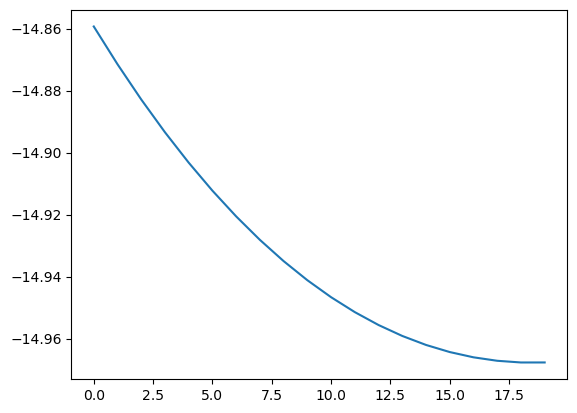

In [15]:
losses = []
for s in np.linspace(1e-4,0.01,20):
    c0 = gci.group_commutator(s, MagneticFieldEvolutionOracle(f))["forwards"]
    losses.append(hamiltonian.expectation((c0+c0+c1)().state()))

print(min(losses))
plt.plot(losses)

In [16]:
print(np.min(losses))
f = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]


-14.967713857597507


IndexError: list index out of range

In [ ]:
gci.count_CNOTs(c0+c0+c1)

90

In [ ]:
gci.count_CZs(c0+c0+c1)

350

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced


-14.973283138160568

-14.975424658560431


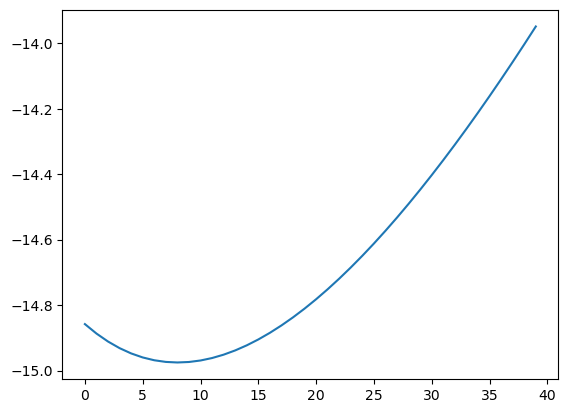

In [17]:
losses = []
for s in np.linspace(1e-4,0.1,40):
    losses.append(gci.loss(s, MagneticFieldEvolutionOracle(f)))

print(min(losses))
plt.plot(losses)

In [18]:
(-14.97-target_energy)/target_energy

-0.02003983335961287

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,19)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
for s in times:
    c2 = gci3.group_commutator(s,MagneticFieldEvolutionOracle(f))["forwards"]
    losses.append(gci3.h_ref.expectation((c2+c2+c)().state()))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

NameError: name 'gci3' is not defined

In [ ]:
gci3.count_CNOTs(c2+c2+c)

135

In [ ]:
gci3.count_CZs(c2+c2+c)

490

In [ ]:
v1_circ = c2+c2+c
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 135 CNOT gates coming from compiled XXZ evolution and 490 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 13.5 and n_CZ/n_qubits = 49.0


-14.963433568882726

([<matplotlib.axis.XTick at 0x70418b0fe720>], [Text(0.01, 0, '0.01')])

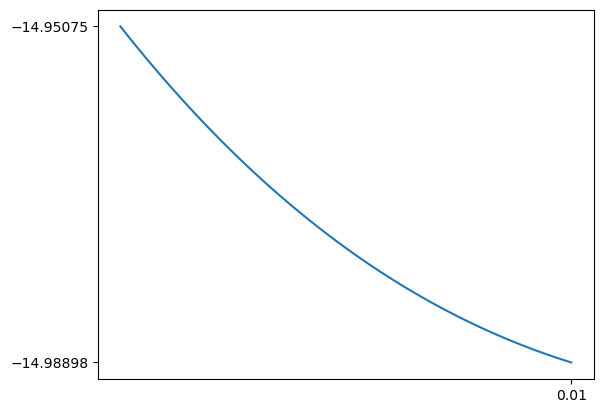

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,49)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
mfeo = MagneticFieldEvolutionOracle(b_rand2)
for s in times:
    losses.append(gci2.loss(s,mfeo))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,49)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
mfeo = MagneticFieldEvolutionOracle(b_rand2)
for s in times:
    losses.append(gci2.loss(s,mfeo))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,19)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
for s in times:
    c2 = gci2.group_commutator(s,MagneticFieldEvolutionOracle(f))["forwards"]
    losses.append(gci3.h_ref.expectation((c2+c2+v1_circ)().state()))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
fields = []
losses = []
steps = []
for j in range(40):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss = gci2.choose_step(d = eo_d,max_evals=14,step_min = 0.0001,step_max = 0.001)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))
plt.show()
plt.plot(steps)



In [ ]:

gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced


fields = []
losses = []
steps = []
for j in range(50):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)
plt.hist(losses)
print(np.min(losses))

In [ ]:
step

0.0024545454545454545

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
gci.loss(0.0024545454545454545, MagneticFieldEvolutionOracle(b_list,name = "D(linear)"))

-14.635706745866539

In [ ]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 45 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 4.5 and n_CZ/n_qubits = 21.0


In [ ]:
gci.h_ref.expectation(gci.get_composed_circuit()().state())

-14.935548641736634

In [ ]:
v1_circ = gci.get_composed_circuit()
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)


In [ ]:

step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-14.979219290252477
0.002466666666666667


In [ ]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-15.012542485184657
0.005636363636363636


In [ ]:
gci2(step, eo_d)
gci2.print_gate_count_report()

The boosting circuit used 315 CNOT gates coming from compiled XXZ evolution and 1050 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 31.5 and n_CZ/n_qubits = 105.0


In [ ]:
v2_circ = gci2.get_composed_circuit()
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v2_circ.invert(), after_circuit=v2_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)

In [ ]:

step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-15.030291801630906
0.0022606060606060606


In [ ]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-15.04753943820458
0.005333333333333333


In [ ]:
gci3(step, eo_d)
gci3.print_gate_count_report()

The boosting circuit used 1665 CNOT gates coming from compiled XXZ evolution and 5250 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 166.5 and n_CZ/n_qubits = 525.0


In [ ]:
(loss-target_energy)/target_energy

-0.014963977595807781